<a href="https://colab.research.google.com/github/bhavnicksm/AyaMCooking/blob/main/AyaMCooking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AyaMCooking

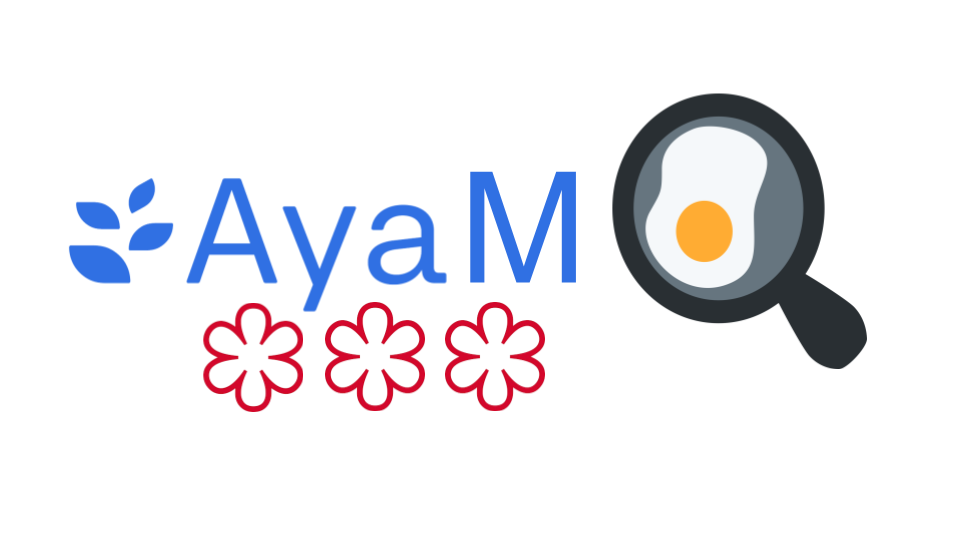

<div style="text-align: center;">
    Bhavnick Minhas<sup>*</sup><sup>1</sup> | Sree Harsha Nelaturu<sup>*</sup><sup>1</sup>

</div>

---

    
<div style="text-align: left; font-size: small;">
    ML efficiency Group, Cohere For AI Community<sup>*</sup>, Equal Contribution<sup>1</sup>.
</div>


Ever wondered about an authentic recipe for Kimchi Jiggae, but are currently in Germany? What are the ingredients needed for an authentic rendition, what to replace in a recipe if you're vegan or allergic?

Go no further! We at team AyaMCooking -- present a effortless pipeline which leverages the massive advances in all things multi-lingual.

We generate recipes from across the world, in the native language of the people who developed it and build a M-RAG index using the Jina model.

Now, as a user -- you can record your question, which is transcribed using Whisper (but faster). This is then used along-with the RAG engine + Cohere ReRank, to provide optimal context (often multilingual) -- to then prompt the very powerful Mystery Aya Model that can understand different languages in one.

What more? We integrate multi-lingual TTS, where the Aya model can now tell you the answer directly using audio.

Cool examples of what we tried out:

1. Mereko Butter Chicken ka swaad pasand hai, but mereko chicken nahi khaana -- kya kar sakta hu? (Translation: I like Butter Chicken, but I do not want to eat chicken -- what can I do)

[Model responded with a Palak Paneer recipe, and a vegan chicken tikka masala recipe]

2. Ich möchte etwas wie Käsespätzle machen, aber nach koreanischer Art. Können Sie mir einen Vorschlag machen?

[I want to make something like Käsespätzle, but Korean style. Can you give me a suggestion?]

The model suggested kimchi jiggae!

## Imports + Utils

These are the required packages for running this notebook. Please note that this takes some time :( and might require you to restart the runtime once. But rest assured, its worth the wait!

Also, you can safely ignore any dependency errors you see here (the packages that have these errors came pre-installed in colab and are not needed for this notebook)

In [ ]:
## imports
!pip install -q 'numpy<2' datasets cohere faster-whisper pydub torch transformers einops faiss-cpu TTS
!pip install -q -U numpy==1.23.0

In [ ]:
## default python imports
import os
import json
import re
import ast
import base64
import io
from dataclasses import dataclass, field
from typing import List, Tuple

## pythonic imports and torch
import numpy as np
import tqdm
import torch
## colab specific imports
from IPython.display import HTML, Audio
from google.colab import output

## HF imports for the embedding model
from transformers import AutoModel
import datasets
from datasets import load_dataset

## Audio model and related imports
from pydub import AudioSegment
from TTS.api import TTS
from faster_whisper import WhisperModel

## cohere
import cohere


## Section 1: Configuration

We define a simple data-class to define the various configuration options required to get the code running. For most folk, nothing will need to change.

We will infer the language code of your response automatically (via Whisper) -- but in case you feel the need to modify any of the defaults -- feel free to do so!

In [ ]:
@dataclass
class Pantry:
  '''
  Args:
    cohere_api_key (str): API key for using the cohere client for the mystery model.
    embedding_model (str): Embedding model of choice pulled from HuggingFace for multi-lingual RAG.
    tts_model (str): The text to speech model used to provide a response based on the Aya model output.
    recording_path (str, WAV file): Path to the file in which to save your recording
    output_path (str, WAV file): Path to the file in which the tts model will save its output
    device (str): automatically inferred whether to run on GPU or CPU. GPU is recommended.
    language_region_pairs (list(tuple(str, str))): list of tuples containing (language, region) pairs
    num_recipes (int): number of recipes to generate
    user_language_code (str): This is automatically inferred using Whisper, but if you want to specify it, feel free.
  '''
  cohere_api_key: str
  whisper_model_size: str = 'large-v2'
  embedding_model: str = 'jinaai/jina-embeddings-v3'
  tts_model: str = 'tts_models/multilingual/multi-dataset/xtts_v2'
  recording_path: str = './user_recorded_audio.wav'
  output_path: str = './model_response.wav'
  device: str = 'cuda' if torch.cuda.is_available() else 'cpu'
  language_region_pairs : List[Tuple[str, str]] = field(default_factory=lambda: [
                                  ('english', 'english'),
                                  ('german', 'german'),
                                  ('french', 'french'),
                                  ('spanish', 'spanish'),
                                  ('indian', 'hindi'),
                                  ('persian', 'persian'),
                                  ('japanese', 'japanese'),
                                  ('korean', 'korean'),
                                  ('turkish', 'turkish'),
                                  ('italian', 'italian')
                              ])
  num_recipes: int = 10
  user_language_code: str = None


## Section 2: Loading the Required Models

### Section 2.1: Initialize the configuration and provide your Cohere API Key, and instantiate the Cohere API.

In [ ]:
cooking_tools = Pantry(cohere_api_key='')
co = cohere.ClientV2(cooking_tools.cohere_api_key)

### Section 2.2: Initialize the Whisper Model (which I hear is fast (*lol*)



In [ ]:
# Loading up the FasterWhisper model
whisper = WhisperModel(cooking_tools.whisper_model_size, device=cooking_tools.device, compute_type="float16")

### Section 2.3: Initialize the Embedding Model


In [ ]:
# Initialize the Jina embedding model
embedding_model = AutoModel.from_pretrained(cooking_tools.embedding_model, trust_remote_code=True, use_flash_attn=False).to(cooking_tools.device)

### Section 2.4: Instantiating the TTS Model

This takes a while....probably 3-4 minutes -- we don't know why D:


In [ ]:
# Load up the tts model
tts = TTS(cooking_tools.tts_model).to(cooking_tools.device).to(cooking_tools.device)

## Section Three: Loading/Generating the Recipe Data

The language pairs provided in the Pantry are used to first create recipe candidates. After this, we generate recipes using aya in the language of origin.
Then we create a huggingface dataset.

If you could like to create your own recipes/recipe candidates -- this is where you'd edit.

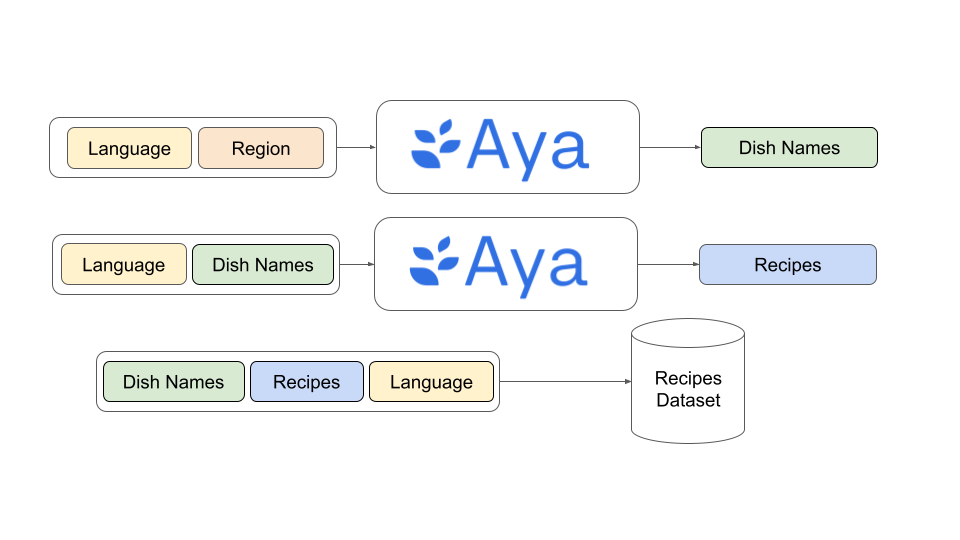

In [ ]:
def create_recipe_candidates(language_region_pairs: List[Tuple[str, str]], num_recipes: int = 10):
  '''
  Uses the pairs + num_recipes to generate list of dishes for the given pair.

  Args:
    language_region_pairs list(tuple(str, str)): list of tuples containing (language, region) pairs
    num_recipes (int): number of recipes you'd like to generate

  Returns:
    recipes_by_language (dict): dictionary with keys as language and values as list of dish names.

  '''
  recipes_by_language = {}
  for lang in cooking_tools.languages:
      language_recipes = co.chat(
          model="mystery-model",
          messages=[
          {
              "role": "user",
              "content": f"Provide me with a python list in correct syntax of {num_recipes} dishes that {lang[0]} people eat, with their name in the {lang[1]} name. Don't list the accompaniements -- just the main dish/appetizer. \
                          Please only generate the list itself, and do not add any text before or after. Thanks!"
          }])
      print(language_recipes.dict()['message']['content'][0]['text'])
      recipes_by_language[lang[0], lang[1]] = ast.literal_eval(language_recipes.dict()['message']['content'][0]['text'])

  return recipes_by_language

In [ ]:
def generate_recipes_with_aya(recipes_by_language: dict):
    '''
    Uses the recipe candidates to actually generate the recipes using the Aya Multilingual Model

    Args:
      recipes_by_language (dict): dictionary with keys as language and values as list of dish names.

    Returns:
      nothing, just dumps to disk.
    '''
    for lang in recipes_by_language:
        for recipe in tqdm.tqdm(recipes_by_language[lang]):
            language, region = lang.split(', ')
            print(f'Working on recipe for {recipe} made by {region} people in {language}.')

            response = co.chat(
                model="mystery-model",
            messages=[
            {
            "role": "user",
            "content": f"I am home-cook, and I would like learn how to cook the {region} dish {recipe} in {language}. \
                        Give me a recipe that includes (dont miss any of them): description of the dish (as Description:), step-by-step instructions (as Instructions:),  allergens (as Allergens:), cooking time (as Cooking Time:),and substitutes for ingredients that are not available outside the country of the recipe's origin (as Substitutes:). \
                        Please be sure to be specific about altenatives/allergens. \
                        Please do not skip any sections I requested and generate in a clear markdown format. \
                        Skip the pleasantries and just give me the recipe and make the format useful for Retrieval Augmented Generation Indexing."}])
            resd = response.dict()
            entry = resd['message']['content'][0]['text']
            new_formatted_entry = {
                'language': language,
                'recipe': entry
            }
            with open(f'recipes.jsonl', 'a', encoding='utf-8') as f:
                f.write(json.dumps(new_formatted_entry, ensure_ascii=False) + '\n')
    print('Recipe dumped to ./recipes.jsonl')



In [ ]:
def create_dataset(cooking_tools: Pantry, use_default: bool = True):
    '''
    Creates/Loads huggingface dataset.
    Args:
      cooking_tools (Pantry) - our configuration options
      use_default (bool) - use our pre-uploaded dataset, or create your own using the functions above

    Returns:
      huggingface dataset
    '''

    if use_default:
        dataset = load_dataset('deepmage121/aya_recipes')
    else:
      recipes_per_language = create_recipe_candidates(language_region_pairs=cooking_tools.language_region_pairs, num_recipes = cooking_tools.num_recipes)
      generate_recipes_with_aya(recipes_by_language=recipes_per_language)
      dataset = load_dataset('json', data_files='recipes.jsonl')

    return dataset


In [ ]:
dataset = create_dataset(cooking_tools)['train']

## Section 4: Transcription from User Audio Input

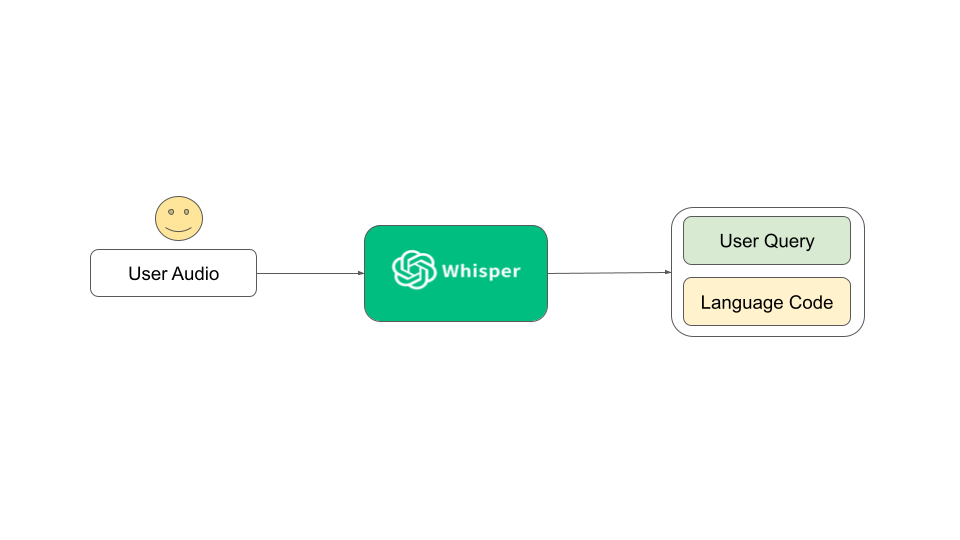

### Section 4.1: Recording User Audio Input

We record audio through the microphone and dump it disk to the path specified in the config.

**NOTE:** The recording fails at times. That's a known issue. You can run the cell again in that case and it should work. We're looking into this. Thank you for your patience.

In [ ]:
import base64
from IPython.display import display, HTML

def record_audio(seconds=3, retries=3):
    """
    Attempts to record audio for the specified number of seconds.
    Retries automatically if recording fails.

    Args:
        seconds (int): Duration for the audio recording.
        retries (int): Maximum number of retries if the recording fails.

    Returns:
        bytes: The recorded audio data in binary format.
    """
    AUDIO_HTML = """
    <script>
    var my_div = document.createElement("DIV");
    var my_p = document.createElement("P");
    var my_btn = document.createElement("BUTTON");
    var t = document.createTextNode("Press to start recording for {{}} seconds");

    my_btn.appendChild(t);
    my_div.appendChild(my_btn);
    document.body.appendChild(my_div);

    var base64data = 0;
    var reader;
    var recorder, gumStream;
    var recordButton = my_btn;

    var handleSuccess = function(stream) {{
      gumStream = stream;
      var options = {{
        mimeType : 'audio/webm;codecs=opus'
      }};
      recorder = new MediaRecorder(stream);
      recorder.ondataavailable = function(e) {{
        var url = URL.createObjectURL(e.data);
        var preview = document.createElement('audio');
        preview.controls = true;
        preview.src = url;
        document.body.appendChild(preview);

        reader = new FileReader();
        reader.readAsDataURL(e.data);
        reader.onloadend = function() {{
          base64data = reader.result;
        }}
      }};
      recorder.start();
    }};

    function resetState() {{
      base64data = 0;
      reader = null;
      recorder = null;
      gumStream = null;
    }}

    resetState(); // Clear any previous state

    recordButton.innerText = "Recording... press to stop";

    navigator.mediaDevices.getUserMedia({{audio: true}}).then(handleSuccess);

    function toggleRecording() {{
      if (recorder && recorder.state == "recording") {{
          recorder.stop();
          gumStream.getAudioTracks()[0].stop();
          recordButton.innerText = "Recorded, please move to the next step";
      }}
    }}

    function sleep(ms) {{
      return new Promise(resolve => setTimeout(resolve, ms));
    }}

    var data = new Promise(resolve=>{{
    recordButton.onclick = () => {{
      toggleRecording();

      sleep(2000).then(() => {{
        resolve(base64data.toString());
      }});
    }}
    }});

    </script>
    """

    attempt = 0
    binary = b''

    while attempt < retries:
        display(HTML(AUDIO_HTML.format(seconds)))
        data = output.eval_js('data')

        # Check if the data is valid, otherwise retry
        if data and ',' in data:
            try:
                binary = base64.b64decode(data.split(',')[1])
                if binary:  # If successfully decoded, return the binary data
                    return binary
            except (IndexError, ValueError):
                print(f"Attempt {attempt + 1} failed. Retrying...")
        else:
            print(f"Attempt {attempt + 1} failed. Retrying...")

        attempt += 1

    print("All attempts failed. Please try recording again.")
    return binary

# Call the function to display the recording interface
audio_binary = record_audio(5)  # Record for 5 seconds

def save_audio_wav(binary_audio, filename='user_recorded_audio.wav'):
    webm_audio = io.BytesIO(binary_audio)
    audio = AudioSegment.from_file(webm_audio, format="webm")
    audio.export(filename, format="wav")
    print(f"Audio saved as {filename}")

# Save as WAV
save_audio_wav(audio_binary)
Audio(audio_binary)

### Section 4.2: Using Whisper to perform Automatic Speech Recognition (ASR)

We use the whisper model to convert your recording to text, as well as infer the language_id directly.

In [ ]:
segments, info = whisper.transcribe(cooking_tools.recording_path, beam_size=5)

print("Detected language '%s' with probability %f" % (info.language, info.language_probability))

language_code = info.language

texts = [segment.text for segment in segments]
query = texts[0]
print(f'The transcription was: {query}')

## Section 5: Multi-lingual Retrieval Augmented Generation (M-RAG)

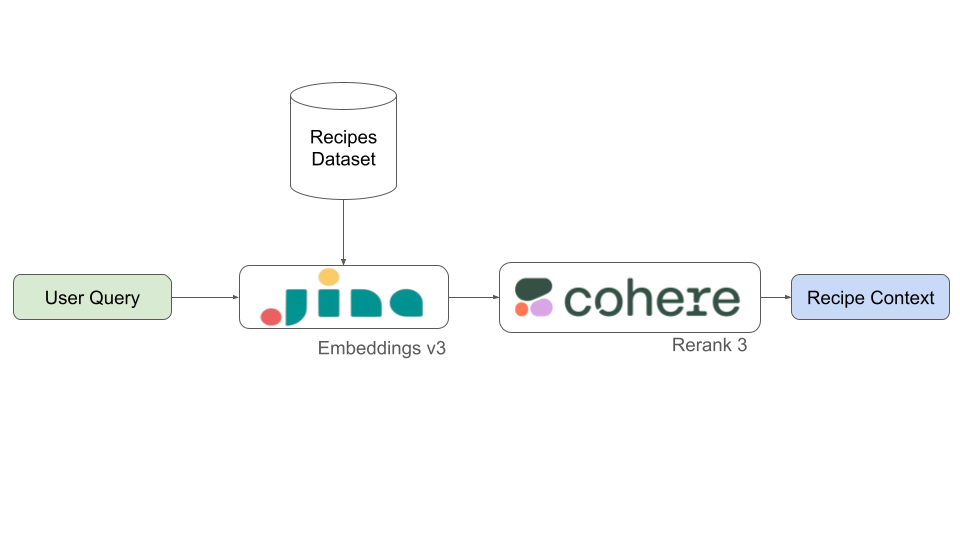

### Section 5.1: Setting up the RAG index

We use Jina embeddings-v3 to construct the RAG index.
This has the following steps:
1. Create a list of recipes
2. Encode the list of recipes using the model
3. Add the embeddings list to the dataset object.
4. Create faiss index using HF dataset's in-built

In [ ]:
recipes = list(dataset['recipe'])
if "embeddings" not in dataset.features:
  embeddings = embedding_model.encode(recipes, task="retrieval.passage")
  dataset = dataset.add_column("embeddings", embeddings.tolist())
  dataset.add_faiss_index("embeddings")
else:
  print(f"Dataset already has an Index on it! Continue on to next steps...")

### Section 5.2: Encoding the query
We encode the query (transcribed audio from before) using the embedding model.

In [ ]:
def get_nearest_recipes(query, embedding_model, dataset, k: int = 10):
    query_embedding = embedding_model.encode(query, task="retrieval.query")
    scores, retrieved_recipes = dataset.get_nearest_examples('embeddings', query_embedding, k=k)
    result = [r for r in retrieved_recipes['recipe']]
    return result

In [ ]:
retrieved_recipes = get_nearest_recipes(query, embedding_model, dataset, k=10)

### Section 5.3: Re-ranking, and getting the context for the user's query

In [ ]:
def rerank_recipes(retrieved_recipes: List[str], query: str, cohere_client, top_n: int = 1):
  response = cohere_client.rerank(
    model="rerank-multilingual-v3.0",
    query=query,
    documents=retrieved_recipes,
    top_n=top_n,
    return_documents=True
  )
  result=[res.document.text for res in response.results]
  return result

context = rerank_recipes(retrieved_recipes, query, co, top_n=1)
print(context[0])

### Section 5.4: Generating the Answer using the Mystery Model

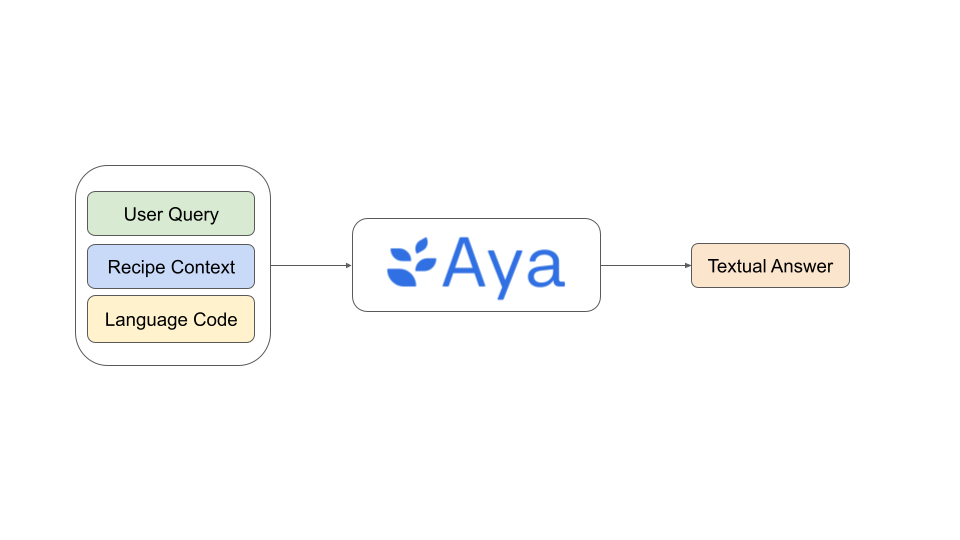

In [ ]:
prompt_template = "Given the context and a query, generate the answer to the query from the given context only.\n\nContext: {context}\n\nQuery: {query}\n\nTranslate the answer to the {language}.\n\nAnswer:"
prompt = prompt_template.format(context=context, query=query, language=language_code)

In [ ]:
def generate_answer(prompt, cohere_client):
  response = co.chat(
    model="mystery-model",
    messages=[
        {
            "role": "user",
            "content": prompt
        }
     ]
  )

  resd = response.dict()
  answer = resd['message']['content'][0]['text']
  return answer

In [ ]:
answer = generate_answer(prompt, co)
print(answer)

## Section 6: Generate an Audio response, based on the M-RAG generation

And...finally we leverage TTS models, to generate the final audio output.

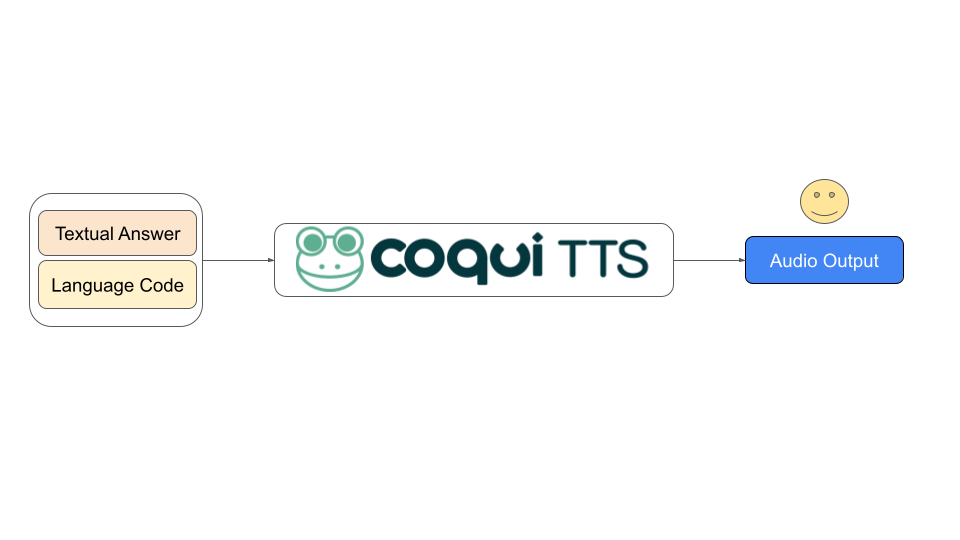

In [ ]:
def cleanup_for_tts(text):
    # Remove markdown headers and formatting
    text = re.sub(r'#{1,6}\s', '', text)
    text = text.replace('**', '')

    # Remove bullet points and numbering
    text = re.sub(r'^\s*[-*]\s', '', text, flags=re.MULTILINE)
    text = re.sub(r'^\s*\d+\.\s', '', text, flags=re.MULTILINE)

    # Remove extra whitespace and newlines
    text = re.sub(r'\n+', ' ', text)

    return text.strip()

answer = cleanup_for_tts(answer)

In [ ]:
def chunk_text(text, chunk_size=250):
    return [text[i:i+chunk_size] for i in range(0, len(text), chunk_size)]

def generate_audio(text_chunks, output_path, speaker, language_code):
    combined_audio = AudioSegment.empty()
    for i, chunk in enumerate(text_chunks):
        temp_file = f"temp_audio_{i}.wav"
        tts.tts_to_file(text=chunk,
                        file_path=temp_file,
                        speaker=speaker,
                        language=language_code,
                        split_sentences=True)
        audio_chunk = AudioSegment.from_wav(temp_file)
        combined_audio += audio_chunk
        os.remove(temp_file)

    combined_audio.export(output_path, format="wav")

text_chunks = chunk_text(answer)
generate_audio(text_chunks, cooking_tools.output_path, "Ana Florence", language_code)

In [ ]:
audio = Audio(cooking_tools.output_path)
display(audio)

That's all folks!

Hope you enjoyed using this notebook.

# Fin.